In [1]:
from pycocotools.coco import COCO
from sklearn import tree, metrics
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.util import crop
from skimage import io, color
from math import floor, ceil
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.decomposition import TruncatedSVD
import json
from LoadLocalCOCO import LoadLocalCOCO as llc
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import pickle
from joblib import dump, load
from tqdm import tqdm
import cv2

%matplotlib inline


In [30]:
# GLCM
from skimage.feature import greycomatrix, greycoprops

In [31]:
def flatten_list(qlist):
    return [y for x in qlist for y in x]

In [32]:
patch_size = 8

In [33]:
train_instance="annotations/instances_train2017.json"
val_instance="annotations/instances_val2017.json"

coco_path = "D:/FSR/COCO/train2017"

classes = ['dog', 'cat']

coco_train = llc(train_instance, coco_path)
coco_val = llc(val_instance, coco_path)

In [34]:
data_train = []
for category in classes:
    data = coco_train.get_cropped_images_flatten_and_resized(category, flatten=False)
    data_train.append(data)

5508it [05:34, 16.47it/s]
2it [00:00, 14.65it/s]Broken images: [7125, 16775, 24247, 24247, 55296, 47386, 69468, 35613, 77325, 12696, 22427, 26321, 54957, 790, 1360, 55478, 42341, 57631, 2400, 10276, 94049, 58741, 5782, 44613, 58741, 24159, 44613, 29176] images
4768it [04:47, 16.61it/s]Broken images: [5617, 711, 39171, 9413, 46749, 18211, 26375, 26375, 26375, 66041] images



In [5]:
np.shape(data_train)

(0,)

In [ ]:
# GLCM

In [36]:
def glcm_feature_extraction_granular(image_data, patch_size, displacement_size, distance=[5], angles=[0], levels=256, symmetric=True, normed=True, features=['contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy', 'correlation']):
    feature_data = []
    for image in image_data:
        img_size = image.shape[:2]
        patch_num = 0
        patch_feature = {}
        if len(image.shape)==3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        for row in range(0, img_size[0], displacement_size):
            if row + patch_size >= img_size[0]:
                continue
            for column in range(0, img_size[1], displacement_size):
                if column + patch_size >= img_size[1]:
                    continue
                img_patch =  image[row:row+patch_size, column:column+patch_size]
                glcm = greycomatrix(img_patch, distances=distance, angles=angles, levels=levels, symmetric=symmetric, normed=normed)
                print(row, column, np.shape(image), patch_num, np.average(img_patch))
                for feature in features:
                    feature_name = f'{feature}_{patch_num}'
                    patch_feature[feature_name] = greycoprops(glcm, feature)[0, 0]
                patch_num+=1
        feature_data.append(patch_feature)
    feature_data = pd.DataFrame(feature_data)
    return feature_data


In [35]:
def glcm_feature_extraction(image_data, distance=[5], angles=[0], levels=256, symmetric=True, normed=True, features=['contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy', 'correlation']):
    feature_data = []
    for image in image_data:
        patch_feature = {}
        if len(image.shape)==3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        glcm = greycomatrix(image, distances=distance, angles=angles, levels=levels, symmetric=symmetric, normed=normed)
        for feature in features:
            patch_feature[feature] = greycoprops(glcm, feature)[0, 0]
        feature_data.append(patch_feature)
    feature_data = pd.DataFrame(feature_data)
    return feature_data

In [7]:
k = [{'a':1, 'b':2}, {'a':1, 'b':2}]
k_df = pd.DataFrame(k)
k_df.head()

,a,b
0,1,2
1,1,2


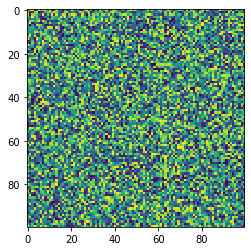

In [2]:
z = np.random.randint(255, size=(100,100),dtype=np.uint8)
plt.imshow(z)

In [49]:
patch_feature = {}

array([[ 41, 108, 182, ..., 172, 179, 137],
       [194, 124,  45, ..., 100,  25, 162],
       [195, 142, 117, ..., 131, 128, 235],
       ...,
       [236,  60, 132, ..., 184, 103, 134],
       [159,  97,   7, ...,  39, 182, 195],
       [ 39,  99,   9, ...,  66, 157, 122]], dtype=uint8)

In [145]:
glcm = greycomatrix(z, distances=[5], angles=[0], levels=256,
                        symmetric=True, normed=True)
res_dis = greycoprops(glcm, 'dissimilarity')[0,0]

In [24]:
res_dis

84.90442105263162

In [3]:
z_random_data = [z, z*3, z-3]

In [4]:
np.shape(z_random_data)

(3, 100, 100)

In [41]:
z_df = glcm_feature_extraction(z_random_data)

In [42]:
z_df.head()

,contrast,dissimilarity,homogeneity,ASM,energy,correlation
0,10957.416000,85.928842,0.012003,0.000069,0.00828,-0.014419
1,10852.829895,85.276632,0.011675,0.000069,0.00828,-0.004111
2,10976.979789,86.005263,0.011988,0.000069,0.00828,-0.014797


In [29]:
np.shape(z_random_data)

(3, 100, 100)

In [59]:
z_df.head()

,contrast_0,dissimilarity_0,homogeneity_0,ASM_0,energy_0,correlation_0,contrast_1,dissimilarity_1,homogeneity_1,ASM_1,...,homogeneity_142,ASM_142,energy_142,correlation_142,contrast_143,dissimilarity_143,homogeneity_143,ASM_143,energy_143,correlation_143
0,4494.916667,53.750000,0.001823,0.026042,0.161374,-0.360298,1957.875000,35.291667,0.028753,0.026042,...,0.003117,0.020833,0.144338,-0.297712,6877.000000,69.166667,0.002993,0.020833,0.144338,-0.458254
1,2484.291667,36.791667,0.099003,0.029514,0.171796,-0.186933,3300.041667,45.375000,0.055470,0.026042,...,0.000825,0.020833,0.144338,-0.293627,2083.208333,38.958333,0.047375,0.021701,0.147314,0.118459
2,4416.875000,51.791667,0.003368,0.026042,0.161374,-0.414976,1769.166667,33.666667,0.029571,0.026042,...,0.003503,0.020833,0.144338,-0.298348,6750.583333,69.916667,0.003181,0.020833,0.144338,-0.632724


In [60]:
z_df.tail()

,contrast_0,dissimilarity_0,homogeneity_0,ASM_0,energy_0,correlation_0,contrast_1,dissimilarity_1,homogeneity_1,ASM_1,...,homogeneity_142,ASM_142,energy_142,correlation_142,contrast_143,dissimilarity_143,homogeneity_143,ASM_143,energy_143,correlation_143
0,4494.916667,53.750000,0.001823,0.026042,0.161374,-0.360298,1957.875000,35.291667,0.028753,0.026042,...,0.003117,0.020833,0.144338,-0.297712,6877.000000,69.166667,0.002993,0.020833,0.144338,-0.458254
1,2484.291667,36.791667,0.099003,0.029514,0.171796,-0.186933,3300.041667,45.375000,0.055470,0.026042,...,0.000825,0.020833,0.144338,-0.293627,2083.208333,38.958333,0.047375,0.021701,0.147314,0.118459
2,4416.875000,51.791667,0.003368,0.026042,0.161374,-0.414976,1769.166667,33.666667,0.029571,0.026042,...,0.003503,0.020833,0.144338,-0.298348,6750.583333,69.916667,0.003181,0.020833,0.144338,-0.632724


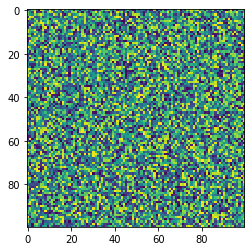

In [39]:
plt.imshow(z_random_data[0])

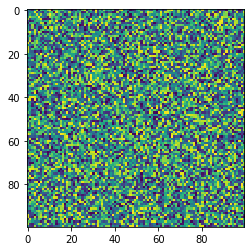

In [40]:
plt.imshow(z_random_data[1])

In [44]:
np.average(z)

127.3769

In [61]:
from scipy.stats import skew, kurtosis

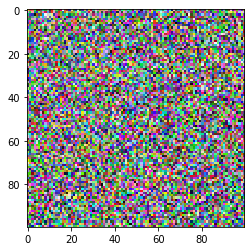

In [7]:
z3 = np.random.randint(255, size=(100, 100, 3),dtype=np.uint8)
plt.imshow(z3)

In [139]:
def modified_skew(image):
    skew_img = 0
    mean = np.average(image)
    dime = np.shape(image)[0]*np.shape(image)[1]
    print(dime, mean)
    for row in range(0, image.shape[0]):
        for column in range(0, image.shape[1]):
            skew_img += np.power(image[row, column] - mean, 3)
            # print(skew_img)
    print(skew_img)
    skew_img *= 1/dime
    print(skew_img)
    # skew_img = np.power(skew_img, 1/3)
    skew_img = np.cbrt(skew_img)
    print(skew_img**1/3)
    if np.isnan(skew_img):
        return 0 
    else:
        return skew_img

def modified_skew2(image):
    skew_img = 0
    mean = np.average(image)
    dime = np.shape(image)[0]*np.shape(image)[1]
    std = np.std(image)
    print(dime, mean)
    for row in range(0, image.shape[0]):
        for column in range(0, image.shape[1]):
            skew_img += np.power((image[row, column] - mean)/std, 3)
    print(skew_img)
    skew_img *= 1/dime
    print(skew_img)
    return skew_img

def modified_kurtosis(image):
    mean = np.average(image)
    std = np.std(image)
    kurt = 0
    for row in range(0, image.shape[0]):
        for column in range(0, image.shape[1]):
            kurt += np.power((image[row, column] - mean)/std, 4) -3
    print(kurt)
    kurt *= 1/dime
    print(kurt)
    return kurt




In [117]:
mean_img = np.average(z3, axis=1)
std_img = np.std(z)
moment = cv2.moments(z)
skew_img = modified_skew(z)
kurtosis_img = kurtosis(z, axis=1)
# print(mean_img, std_img, skew_img, kurtosis_img)
# moment

10000 127.3769
-63565825.8077896
-6356.582580778961
nan


In [108]:
np.average(z3[:,:,0])

127.1904

In [109]:
np.average(z3[:,:,1])

126.5467

In [110]:
np.average(z3[:,:,2])

127.189

In [140]:
modified_skew(z3[:,:,1])

10000 126.5467
6461248.647751536
646.1248647751537
2.8817141346629582


8.645142403988874

In [141]:
modified_skew(z3[:,:,2])

10000 127.189
5749422.595381664
574.9422595381665
2.7717463806006855


8.315239141802056

In [143]:
modified_skew(z3[:,:,0])

10000 127.1904
-13467483.836574718
-1346.748383657472
-3.6810713288819024


-11.043213986645707

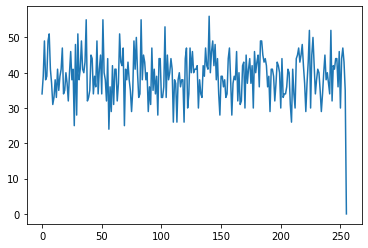

In [134]:
# plt.hist(z3[:,:,0].ravel(), bins=256, range=(0.0, 1.0), fc='k', ec='k')
hist_1 = cv2.calcHist([z3[:,:,0]], [0], None, [256], [0,256])
plt.plot(hist_1)

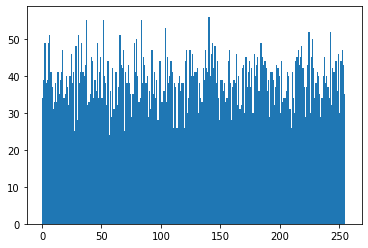

In [135]:
plt.hist(z3[:,:,0].ravel(),256,[0,256]) 
plt.show() 

In [137]:
np.power(-12, 1/3)

nan

In [138]:
np.cbrt([-12])

array([-2.28942849])

In [128]:
modified_skew(z_random_data[0])

10000 127.3769
-63565825.8077896
-6356.582580778961
nan


0

In [131]:
modified_kurtosis(z_random_data[0])

-11927.26066648997
-1.1927260666489972


-1.1927260666489972

In [120]:
np.shape(z - np.average(z))

(100, 100)

In [149]:
# color moment
# moment 1: mean
# moment 2: standard deviation
# moment 3: skewness
# moment 4: kurtosis


def color_moment_extraction_3channel(image_data):
    feature_data = []
    for image in image_data:
        image_features = {}
        for ch in range(image.shape[2]):
            mean_img = np.average(image[:,:,ch])
            image_features[f'mean_{ch}'] = mean_img
            std_img = np.std(image[:,:,ch])
            image_features[f'std_{ch}'] = std_img
            skew_img = modified_skew(image[:,:,ch])
            image_features[f'skewness_{ch}'] = skew_img
            kurtosis_img = modified_kurtosis(image[:,:,ch])
            image_features[f'kurtosis_{ch}'] = kurtosis_img
        feature_data.append(image_features)
    return feature_data

def color_moment_extraction_1channel(image_data):
    feature_data = []
    for image in image_data:
        image_features = {}
        mean_img = np.average(image)
        image_features['mean'] = mean_img
        std_img = np.std(image)
        image_features['std'] = std_img
        skew_img = modified_skew(image)
        image_features['skewness'] = skew_img
        kurtosis_img = modified_kurtosis(image)
        image_features['kurtosis'] = kurtosis_img
        feature_data.append(image_features)
    return feature_data


In [151]:
color_moment_extraction([z3])

1
1
1


In [79]:
dime

10000

In [4]:
# texture
# HOG
from skimage import feature

In [8]:
hog_f = feature.hog(z3, orientations=9, pixels_per_cell=(8, 8),
	cells_per_block=(2, 2), transform_sqrt=True, block_norm="L1")
hog_f

array([0.03602492, 0.01537666, 0.04003997, ..., 0.02453649, 0.01755788,
       0.03418941])

In [9]:
len(hog_f)

4356

In [10]:
z32 = z3*2

In [11]:
hog_f2 = feature.hog(z32, orientations=9, pixels_per_cell=(8, 8),
	cells_per_block=(2, 2), transform_sqrt=True, block_norm="L1")
hog_f2

array([0.04393967, 0.01680141, 0.02312942, ..., 0.02951595, 0.02781978,
       0.03707366])

In [12]:
len(hog_f2)

4356

In [13]:
# k_class = ['a', 'b']
# for
data_z = 5000*[hog_f]+5000*[hog_f2]
label_z = 5000*['a']+5000*['b']

In [14]:
np.shape(data_z)

(10000, 4356)

In [15]:
df_z = []
for row, label in zip(data_z, label_z):
    dct_z = {}
    for i, val in enumerate(row):
        dct_z[f'hog_{i}'] = val
    dct_z['label'] = label
    df_z.append(dct_z)
df_z = pd.DataFrame(df_z)

In [25]:
del df_z

In [16]:
df_z.head() # asumsinya normal distribution

,hog_0,hog_1,hog_2,hog_3,hog_4,hog_5,hog_6,hog_7,hog_8,hog_9,...,hog_4347,hog_4348,hog_4349,hog_4350,hog_4351,hog_4352,hog_4353,hog_4354,hog_4355,label
0,0.036025,0.015377,0.04004,0.036931,0.049581,0.025817,0.012166,0.008825,0.018598,0.036078,...,0.031013,0.022579,0.045823,0.031792,0.010525,0.021102,0.024536,0.017558,0.034189,a
1,0.036025,0.015377,0.04004,0.036931,0.049581,0.025817,0.012166,0.008825,0.018598,0.036078,...,0.031013,0.022579,0.045823,0.031792,0.010525,0.021102,0.024536,0.017558,0.034189,a
2,0.036025,0.015377,0.04004,0.036931,0.049581,0.025817,0.012166,0.008825,0.018598,0.036078,...,0.031013,0.022579,0.045823,0.031792,0.010525,0.021102,0.024536,0.017558,0.034189,a
3,0.036025,0.015377,0.04004,0.036931,0.049581,0.025817,0.012166,0.008825,0.018598,0.036078,...,0.031013,0.022579,0.045823,0.031792,0.010525,0.021102,0.024536,0.017558,0.034189,a
4,0.036025,0.015377,0.04004,0.036931,0.049581,0.025817,0.012166,0.008825,0.018598,0.036078,...,0.031013,0.022579,0.045823,0.031792,0.010525,0.021102,0.024536,0.017558,0.034189,a


In [17]:
label_a = df_z[df_z.label=='a'].mean()

In [18]:
label_a

hog_0       0.036025
hog_1       0.015377
hog_2       0.040040
hog_3       0.036931
hog_4       0.049581
              ...   
hog_4351    0.010525
hog_4352    0.021102
hog_4353    0.024536
hog_4354    0.017558
hog_4355    0.034189
Length: 4356, dtype: float64

In [22]:
pca = PCA(n_components = 25)
pca.fit(data_z)
reduced_data_z_pca = pca.transform(data_z)

In [24]:
reduced_data_z_pca.shape

(10000, 25)

In [26]:
pca.explained_variance_ratio_

array([1.00000000e+00, 3.24700505e-25, 9.98402083e-33, 9.98402083e-33,
       9.98402083e-33, 9.98402083e-33, 9.98402083e-33, 9.98402083e-33,
       9.98402083e-33, 9.98402083e-33, 9.98402083e-33, 9.98402083e-33,
       9.98402083e-33, 9.98402083e-33, 9.98402083e-33, 9.98402083e-33,
       9.98402083e-33, 9.98402083e-33, 9.98402083e-33, 9.98402083e-33,
       9.98402083e-33, 9.98402083e-33, 9.98402083e-33, 9.98402083e-33,
       9.98402083e-33])

In [28]:
# scatter preview
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})
RS = 123

In [29]:
def plot_scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts